<font><div><center> 
# Failure during Observation 1 of Global Alignment
</center></div></font> 

This notebook is for the case that guiding fails during Global Alignment (1 or 2) observation 1 due to a failure of ID, ACQ, or TRK when trying for the 2nd or 3rd time to engage closed-loop guiding. 

<font color='white'><div style='background-color: rgba(255, 99, 71)'> 
This notebook currently has this set up with GA 1 data from MIRAGE. If you need to use this for commissioning, save a copy of this notebook and replace the indicated options in the cells below with the necessary information. 
</div></font>

To run a cell, press Shift+Enter on your keyboard

In [1]:
# Import necessary packages

# Standard Library
from glob import glob
import os
from io import StringIO
from functools import reduce

# Third Party Packages
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

%matplotlib inline

# Guiding Failure in OTE-07 Observation 1

* [Before running this notebook](#Before-running-this-notebook)
* [Functions](#Functions-used-below)
* [Parameters to change](#Parameters-to-change)
* [Examine the data from the failed observation](#Examine-the-data-from-the-failed-observation)

<font color='SlateBlue'> <div> 
### Before running this notebook:
###    
</div></font>
1. Make a directory to store all the data for this analysis (I recommend doing this where we save the data, and naming the directory "ga_failure")

2. Copy all NIRCam and FGS full frame data that was successfully taken to the above directory

3. Make a subdirectory for each attempt of track that has data (the failed attempt will at least have ID data and we want to include this)

4. Move all guiding products (ID, ACQ, TRK data) for the guiding attempts to their respective directories

5. For easy access, you can also move the ID.star file and ACQ.prc file that you made from the LOS-02 observation 2 data for OTE-07 obs 1 to a `command` directory

This is what this might look like (this is an example for if it failed on the second guiding attempt in ID):
```
- ga_failure/
    - command/
        - for_ote07_obs1_G1_ID.star
        - for_ote07_obs1_G1_ACQ.prc
    - track_attempt_1/
        - gs-idstrips.fits
        - gs-acq1.fits
        - gs-acq2.fits
        - gs-track.fits
    - track_attempt_2/
        - gs-idstrips_set1.fits
        - gs-idstrips_set2.fits
        - gs-idstrips_set3.fits
    - jw01141001001_02101_00001_nrca3_cal.fits
    - jw01141001001_02101_00002_nrca3_cal.fits
    - jw01141001001_03101_00001_g1_cal.fits
```

You will have one set of ID strips for each of the three attempts to get into ID for each configuration that you included in the override file. In the above example, only one configuration was commanded (for simplicity). 

6. Run one of the retrieved ID strips (if you have multiple configurations, do this for each) from the failed attempt through DHAS, using the ID.star file in the `command` directory. This will hopefully show that the run fails. This is expected! What we want to get here is the bright object list (.bobj) from DHAS so we know the count rates actually measured for each PSF. 


<font color='Tomato'> <div style='background-color: rgba(255, 99, 71, 0.3)'><center> 
##    
## You will not be able to run this notebook without changing the below parameters
##    
</center></div></font>

<font><div><center> 
## Parameters to change 
</center></div></font>  

To run this notebook for your data set where guiding has failed, you will need to change the parameters in the call below to match your data. This notebook is set up such that this is the ONLY cell you should have to update. 

In [2]:
# Values that have been set in MAGIC

threshold = .6  # Value in MAGIC to set the count rate threshold
guider = 1  # FGS dectector that will be used for observation 1 -- this will always be 1 for OTE-07/GA1
nrc_detector = 'A3'  # NIRCam detector used for NIRCam observations

In [34]:
# Information about the command used to for the override

# Out Directory passed intp MAGIC
commanded_out_dir = '***REMOVED***/share/wf_guiding/ga_guiding_failure_analysis_plan' 

# Root passed into MAGIC
root_psuedo_fgs = 'for_ote07_obs1'

# Check that there is data at that location
if not os.path.exists(os.path.join(commanded_out_dir, 'out', root_psuedo_fgs)):
    print("ERROR: The directory that you listed does not exist. Check that is it is pointing to the correc place.")

# Number associated with the config used for the commands. Expecting a list up to 3
config_numbers = [1,] # [1, 2, 3]

In [49]:
# The location of data from the observatory
failed_observation_products = '***REMOVED***/share/wf_guiding/ga_guiding_failure_analysis_plan/ga_failure'

# For each step where you have the data, provide the filename of the images in the above directory
# It's likely that the below filenames are already correct, but be sure to check them!
# If you do not have all of this data, you can delete the file name or comment out the line, or leave it as is
#  the code is smart enough to know if what you don't have and not look for it

#  --Before the first mirror move--
nrc_track_1_filename = 'jw01141001001_02101_00001_nrca3_cal.fits'

#  --After the first mirror move--
nrc_coarse_1_filename = 'jw01141001001_02101_00002_nrca3_cal.fits'
fgs_coarse_1_filename = 'jw01141001001_03101_00001_g1_cal.fits'
nrc_track_2_filename = 'jw01141001001_05101_00001_nrca3_cal.fits'

#  --After the second mirror move--
nrc_coarse_2_filename = 'jw01141001001_05101_00002_nrca3_cal.fits'
fgs_coarse_2_filename = 'jw01141001001_06101_00001_g1_cal.fits'

# What track attempt did it fail on?
fail_attempt = 3

In [62]:
# The bright object list that will come out of running the failed ID strips through DHAS
# If you have multiple configs, you might have to change the path below
bright_object_list_config1 = glob(os.path.join(failed_observation_products, f'track_attempt_{fail_attempt}',
                                               'idSim_cfg_default_*.bobj'))[0]
print(bright_object_list_config1)

/Users/kbrooks/Desktop/ga_failure/track_attempt_3/idSim_cfg_default_20210727_105820.bobj


In [51]:
# CAR information 
program_id = 1141 # GA1; use 1151 for GA2
observation = 1

<font color='DodgerBlue'> <div style='background-color: rgba(30, 144, 255, 0.3)'><center> 
##    
## Run the following cells without changing them
##    
</center></div></font>

## Functions used - leave unchanged

In [52]:
# Find the indices of the object in the bright object list that most closely matches the commanded values

def distance(y1, x1, y2, x2):
    """Find the combined distances between x and y points"""
    return np.abs((y1-y2)+(x1-x2))


def find_bright_obj(y, x, bright_obj_df):
    """Find the index in the bright object list that has the minimum distance to a point"""
    index = bright_object_df.apply(
        lambda row: distance(y, x, row['FPA Row (pixels)'], row['FPA Column (pixels)']), 
        axis=1)
    return index.idxmin()


def match_bright_obj_to_command(commanded, bright_obj_df):
    """For each x, y position in the commanded list, find the index of the PSF in the bright object list
    that is the closest. 
    """
    matching_indices = commanded.apply(
                                        lambda row: find_bright_obj(row['y'], row['x'], bright_obj_df), 
                                        axis=1).values
    return matching_indices


<font><div><center> 
## Segments Labels
</center></div></font>  


<table><tr><td><img src="../g1_psf_orientation_raw_magic.png" style="width: 400px;"></td><td><img src="../g2_psf_orientation_raw_magic.png" style="width: 400px;"></td></tr></table>

<font><div><center> 
# Examine the data from the failed observation
</center></div></font>  

All of the data below is in the SCI frame which is different from the frame the the MAGIC products are in. The plots below are informative *only* and are not meant to be used to extrapolate information.

In [57]:
# Open the images
try: 
    nircam_track_1 = fits.getdata(os.path.join(failed_observation_products, nrc_track_1_filename))

    nircam_coarse_1 = fits.getdata(os.path.join(failed_observation_products, nrc_coarse_1_filename))
    fgs_coarse_1 = fits.getdata(os.path.join(failed_observation_products, fgs_coarse_1_filename))
    try:  
        nircam_track_2 = fits.getdata(os.path.join(failed_observation_products, nrc_track_2_filename))
        mirror_move_2 = True
    except (FileNotFoundError, IsADirectoryError):
        print('Observation failed to get into track after first mirror move')
        mirror_move_2 = False

    if mirror_move_2:
        nircam_coarse_2 = fits.getdata(os.path.join(failed_observation_products, nrc_coarse_2_filename))
        fgs_coarse_2 = fits.getdata(os.path.join(failed_observation_products, fgs_coarse_2_filename))
except (FileNotFoundError, IsADirectoryError):
    print('Observation failed to get into track on the first attempt. Only guider data will be available.')

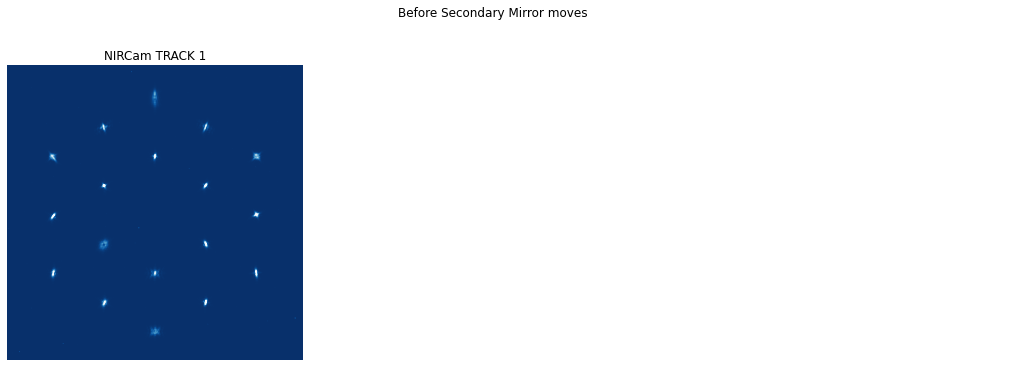

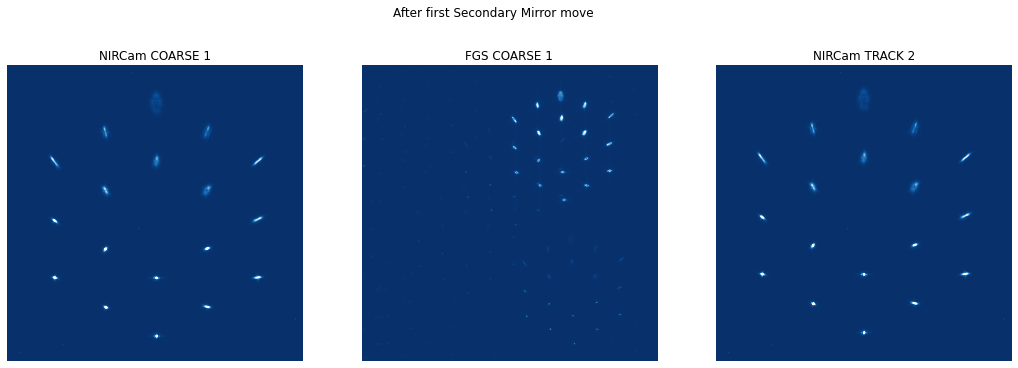

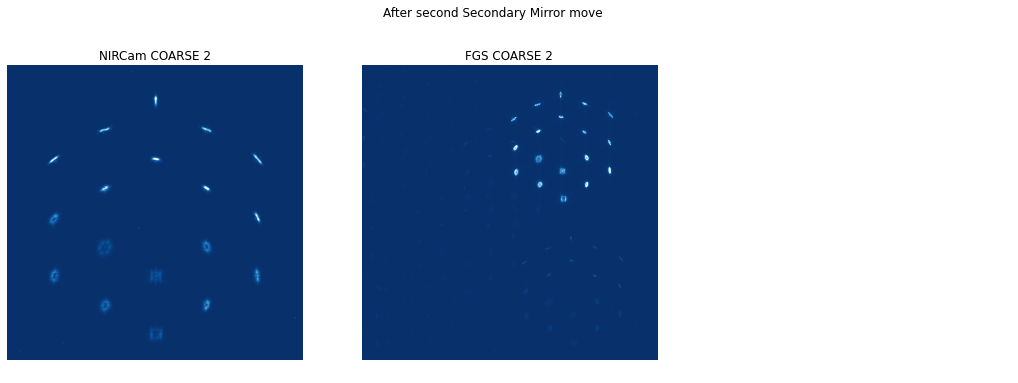

In [61]:
# Plot images
try:
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(nircam_track_1, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
    ax[0].set_title('NIRCam TRACK 1')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    fig.suptitle("Before Secondary Mirror moves")
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(nircam_coarse_1, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
    ax[0].set_title('NIRCam COARSE 1')
    ax[0].axis('off')
    ax[1].imshow(fgs_coarse_1, cmap='Blues_r', vmin=0, vmax=50, origin='lower')
    ax[1].set_title('FGS COARSE 1')
    ax[1].axis('off')
    fig.suptitle("After first Secondary Mirror move")

    try:
        ax[2].imshow(nircam_track_2, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
        ax[2].set_title('NIRCam TRACK 2')
        ax[2].axis('off')
        plt.show()

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        ax[0].imshow(nircam_coarse_2, cmap='Blues_r', vmin=0, vmax=10000, origin='lower')
        ax[0].set_title('NIRCam COARSE 2')
        ax[0].axis('off')
        ax[1].imshow(fgs_coarse_2, cmap='Blues_r', vmin=0, vmax=50, origin='lower')
        ax[1].set_title('FGS COARSE 2')
        ax[1].axis('off')
        ax[2].axis('off')
        fig.suptitle("After second Secondary Mirror move")
        
    except NameError:
        plt.show()
        print('Failure after first Secondary Mirror move')
except NameError:
    print('No full frame data NIRCam or FGS to show')

<font><div><center> 
#  Compare the Guiding Selections with the Bright Object List
</center></div></font>
    
Take the ID strips for a failed run (from sky/MAST) and run them through the DAHS to get bright object list Compare the bright object list to the command

## Config 1

### Bright Object List

In [63]:
# Print the bright object list filename
bright_object_list_config1

'/Users/kbrooks/Desktop/ga_failure/track_attempt_3/idSim_cfg_default_20210727_105820.bobj'

In [64]:
# Read the bright object list into a table (Data Frame)
bright_object_df = pd.read_csv(bright_object_list_config1)

# Display the table
bright_object_df

,Cand#,Strip#,CDS#,FPA Row (pixels),FPA Column (pixels),FPA Peak Signal (counts),FPA Count Sum (counts)
0,0,10,1,548,747,6103,43139
1,1,13,1,716,480,4737,35405
2,2,13,2,708,641,3796,28817
3,3,10,2,540,553,3519,25706
4,4,7,1,375,823,3458,25530
5,5,19,1,1040,655,3296,24653
6,6,7,2,381,810,3497,25470
7,7,16,1,884,558,3037,23198
8,8,10,2,557,547,3075,22368
9,9,7,2,377,620,3043,22100


In the above dataframe, the 'FPA Column (pixels)' column corresponds to 'x', the 'FPA Row (pixels)' column corresponds to 'y', and the 'FPA Count Sum (counts)' is our 3x3 count rate that is labelled 'countrate' in the guiding selections file.

In [65]:
psuedo_fgs = fits.getdata(glob(os.path.join(commanded_out_dir, 'out', root_psuedo_fgs, 
                                            f'guiding_config_{config_numbers[0]}',
                                            'FGS_imgs', '*.fits'))[0])

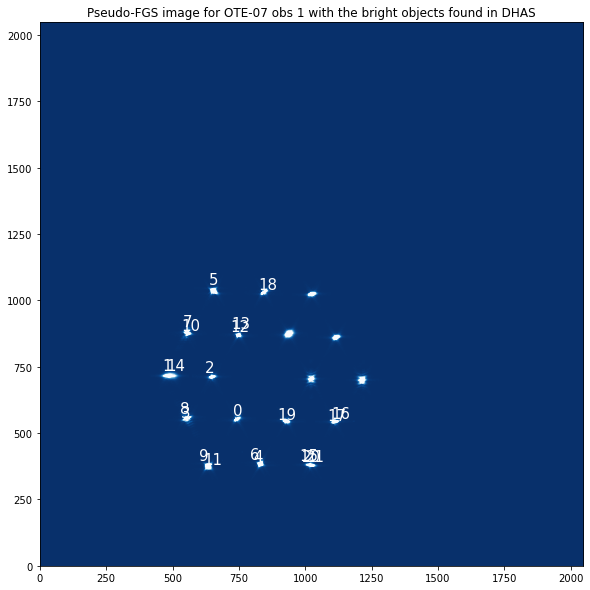

In [66]:
# Plot the bright objects that made this list on top of the Pseudo FGS image that you made when you made 
#  the command
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')

for i, (column, row) in enumerate(zip(bright_object_df['FPA Column (pixels)'].values, 
                                  bright_object_df['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column-20, row+20), color='white', fontsize=15)

plt.title('Pseudo-FGS image for OTE-07 obs 1 with the bright objects found in DHAS')
plt.show()

### Guiding Selections for Guiding Configuration 1

In [67]:
# Guiding selections file
# The first row is the guide star, subsequent rows are reference stars. Order of ref stars doesn't matter.
commanded = pd.read_csv(os.path.join(commanded_out_dir, 'out', root_psuedo_fgs, f'guiding_config_{config_numbers[0]}',
                        f'shifted_guiding_selections_{root_psuedo_fgs}_G{guider}_config{config_numbers[0]}.txt'),
                        skiprows=1, delimiter=' ', names=['y', 'x', 'countrate'])

# Add the count rate threshold to the table
thresholds = threshold * commanded['countrate'].values

commanded['threshold'] = thresholds

# Display the table
commanded

,y,x,countrate,threshold
0,1023.5,1023.5,84046.0,50427.6
1,1034.5,653.5,44164.0,26498.4
2,374.5,632.5,33700.0,20220.0


The first entry (index 0) is your guide star. The next two entries (indices 1 and 2) are your reference stars

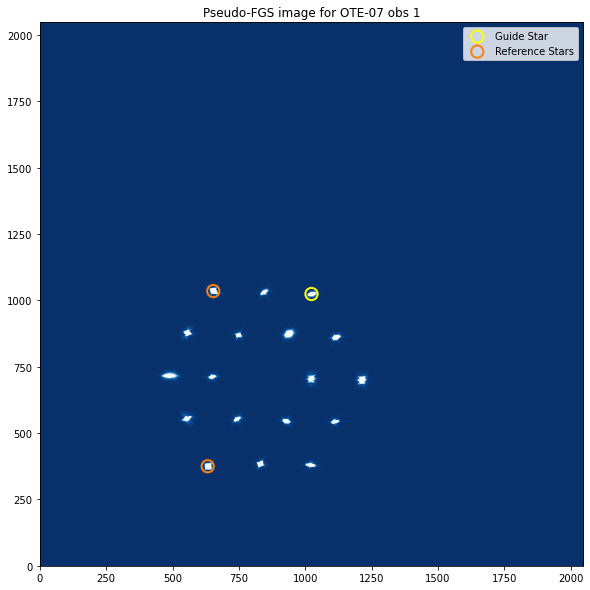

In [68]:
# Plot our Psuedo FGS image with the guiding selections highlighted
image_filename = os.path.join(commanded_out_dir, 'out', root_psuedo_fgs, 'guiding_config_1', 'FGS_imgs', 
                              f'shifted_{root_psuedo_fgs}_G{guider}_config{config_numbers[0]}.fits')

# Load in the image
psuedo_fgs = fits.getdata(image_filename)

# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=150, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1:], commanded['y'].values[1:], s=150, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Stars")
plt.legend()
plt.title('Pseudo-FGS image for OTE-07 obs 1')
plt.show()

### Update the Commanded dataframe with the counts and threshold during ID - for comparison with the bright objects

## Cross-match the command with the bright object list 

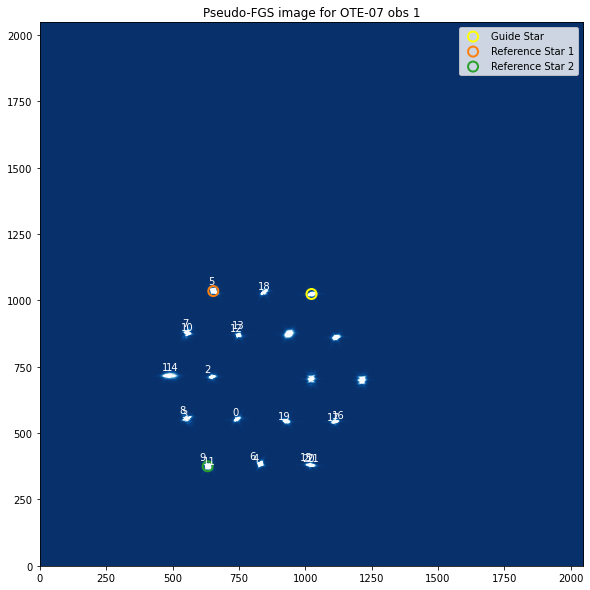

In [72]:
# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='lower')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=100, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1], commanded['y'].values[1], s=100, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Star 1")
plt.scatter(commanded['x'].values[2], commanded['y'].values[2], s=100, facecolors='none',  edgecolors='C2',
            linewidths=2.0, label="Reference Star 2")
for i, (column, row) in enumerate(zip(bright_object_df['FPA Column (pixels)'].values, 
                                  bright_object_df['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column-20, row+20), color='white')
plt.legend()
plt.title('Pseudo-FGS image for OTE-07 obs 1')
plt.show()

<font color='SlateBlue'> <div>

### CHECK 1: Did the commanded objects even make it on the bright object list??    
 
</div></font>

<font color='MediumSeaGreen'><div>
### Yes
</div></font>
    
You can run the next cells. If not, go [here](#No).

In [73]:
matching_indices = match_bright_obj_to_command(commanded, bright_object_df)
print('Guide Star: {}\nRef 1: {}\nRef 2: {}\n'.format(*matching_indices))

Guide Star: 18
Ref 1: 5
Ref 2: 11



In [107]:
# If the above algorithm doesn't choose the correct indicies (based on the plot above), you can overwrite that 
#  array below, uncomment the line, and run the cell.
# matching_indices = [11, 1, 9]

In [78]:
selected_bright_object_df = bright_object_df.loc[matching_indices]

selected_bright_object_df = selected_bright_object_df[['FPA Row (pixels)', 'FPA Column (pixels)', 
                                                       ' FPA Count Sum (counts)']]

selected_bright_object_df

,FPA Row (pixels),FPA Column (pixels),FPA Count Sum (counts)
18,1023,843,8536
5,1040,655,24653
11,363,636,20308


#### Add the commanded counts and threshold in counts to the commanded data frame

In [88]:
# Frame time for ID
t_id = 0.3406 

# Include counts for ID
commanded['id counts'] = commanded['countrate'].values*t_id

# Include thresholds for ID
commanded['id threshold'] = commanded['threshold'].values*t_id

# Display new data frame
commanded

,y,x,countrate,threshold,id counts,id threshold
0,1023.5,1023.5,84046.0,50427.6,28626.0676,17175.64056
1,1034.5,653.5,44164.0,26498.4,15042.2584,9025.35504
2,374.5,632.5,33700.0,20220.0,11478.2200,6886.93200


TODO: What now?

<font color='Tomato'><div>
### No
</div></font>

This is why it probably failed (the FGS team will be able to confirm this). Either:
1. Go back and recreated your command with wider threshold value OR 

2. Make new selections. What you choose will depend on at what point in the observation you failed, and if you have to move through all the mirror moves again. 

If making a wider threshold, re-run MAGIC:
1. Load the unshifted guiding selections for this or all of the configs into the Star Selection section of the GUI

2. Change the threshold in the FSW File Writer section and click "Run"

3. Once the new ID.star and ACQ.prc files are written, test those in the DHAS with the ID strips that were retrieved from MAST to make sure that the threshold will be sufficient

If making new selections:
1. First check what objects were put on the bright object list for the other track attempts

2. See if there is one or more configurations that follow all recommendations for selecting guide and reference stars AND makes it on to the bright object list for all three guiding attempts, record the segment PSFs that follow these guidelines

3. In MAGIC, make sure Click-to-select is still checked in the Star Selection section of the GUI

4. Click Run 

5. Select the segments that you identified in step 2 above

6. Once the new ID.star and ACQ.prc files are written, test those in the DHAS with the ID strips that were retrieved from MAST for each guiding attempt, to make sure that the selections will be successful

<font color='SlateBlue'> <div>

### CHECK 2: Were more than one bright objects found for selected PSFs?    
 
</div></font>

<font color='MediumSeaGreen'><div>
### Yes
</div></font>

Identify which bright objects are associated with each of the selected PSFs and look at their entries in the bright_obj_list data frame

<font color='Tomato'><div>
### No
</div></font>
Well that's good!

### About this notebook:
Author: K. Brooks
Last Updated: 27 July, 2021